<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques that are used to avoid overfitting (but haven't practiced them yet). In this project, we'll practice a fundamental method for avoiding overfitting that is commonly referred to as: _train/test split validation_. 

This is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we will be splitting the data into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California, 20 percent data from elsewhere, and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case, we've still overfit on our data set because we did not sufficiently randomize the data.

Note: In a situation like this, you could use a technique called _k-fold cross-validation_, which is cross-validation applied to more than two subsets. In particular, in k-fold cross-validation, you'd partition your data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. You would do this for each of the possible $k-1$ subsets.

# Project Requirements

The goal of this project will be to create a test-training split to compare multiple models on the same Boston housing data set. For example, you might choose to compare different linear models on the same data.

In this project, you'll fit two to three different models on the Boston housing data. For example, you could pick two different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Work with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train your model on the training data.
* Evaluate your model on the test data.
* Repeat with other variables.
* Rank the models by how well they score on the testing data set. 
* Don't forget to interpret your findings! 



A k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression

As a real estate developer, you are being asked to model the median home price of various houses in the city of Boston using data from the US census. Your goal is to predict a continuous, numeric output (price) based on a combination of discrete features that you choose.

In [69]:
import matplotlib.pyplot as plt

% matplotlib inline

In [208]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.pipeline import Pipeline
import seaborn as sns

boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])
XY = X.merge(y, left_index = True, right_index = True)
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### REQUIRED: Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it _ought_ to be pretty clean, but you should always perform exploratory data analysis.

In [13]:
# Exploratory data analysis.
# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column

In [14]:
X.isnull().sum() # Total nulls, no missing values

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [15]:
# Data types
X.dtypes 

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
dtype: object

In [16]:
# Rows and columns in data
X.shape 

(506, 13)

In [72]:
# Summary statistics
X.describe() 

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [18]:
# Number of unique values
X.nunique() 

CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
dtype: int64

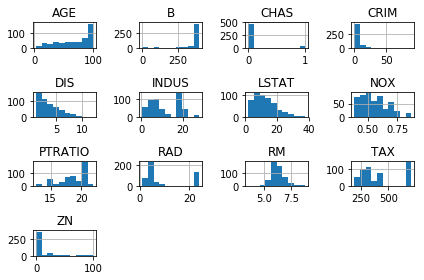

In [19]:
# Explore histograms and look for good distributions
X.hist()
plt.tight_layout()

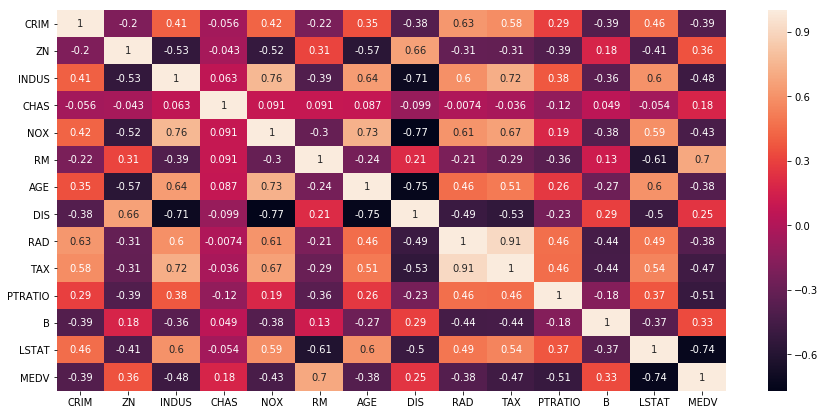

In [73]:
# Look for correlations
XY_CORR = XY.corr()
plt.figure(figsize=(15,7))
sns.heatmap(XY_CORR, annot=True)

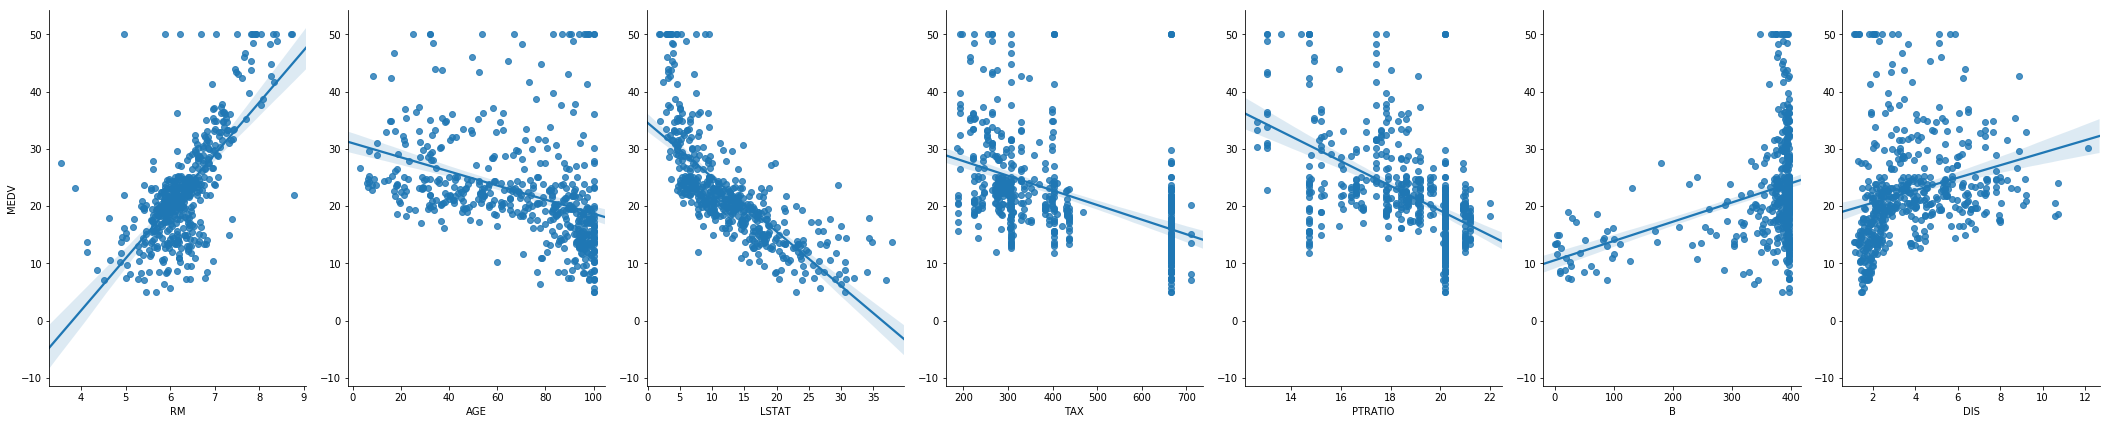

In [138]:
# Explore data, look for linear relationships
sns.pairplot(XY, x_vars = ['RM', 'AGE', 'LSTAT','TAX','PTRATIO','B','DIS'], y_vars='MEDV', size = 6, aspect=0.7, kind='reg')

## Using `scikit-learn` Linear Regression

### REQUIRED: Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict your target variable, MEDV.
Score and plot your predictions. What do these results tell us?

In [194]:
def multiple_scores(df, features):
    X1 = df[features]

    X_train, X_test, y_train, y_test = train_test_split(X1,y, random_state=42)
    
    lr_preds = LinearRegression() # instantiate model
    lr_preds.fit(X_train, y_train) # fit model
    
    y_pred = lr_preds.predict(X_test)
    print(' ')
    print('Intercept: ',lr_preds.intercept_)
    print('Score: ', lr_preds.score(X_train,y_train))
    print('Coef: ', lr_preds.coef_)
    print('R^2 Score: ', metrics.r2_score(y_test, y_pred))
    print(' ')
    return ("MAE Score: {}".format(metrics.mean_absolute_error(y_test, y_pred))), ("MSE Score: {}".format(metrics.mean_squared_error(y_test, y_pred))), ("RMSE Score: {}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))) 

In [214]:
# Print test scores for different combinations of features
print(multiple_scores(X,['RM', 'LSTAT', 'DIS', 'AGE']))
print(multiple_scores(X,['RM', 'ZN', 'DIS'])) 
print(multiple_scores(X,['B', 'LSTAT', 'PTRATIO','DIS']))
print(multiple_scores(X,['RM','LSTAT', 'PTRATIO', 'B'])) 
print(multiple_scores(X,['RM','LSTAT', 'PTRATIO', 'CHAS'])) # feature combination that provides highest R2 score

 
Intercept:  [3.3168536]
Score:  0.6627736211280004
Coef:  [[ 5.20225484 -0.69074769 -0.7032659  -0.02914282]]
R^2 Score:  0.5859092810251847
 
('MAE Score: 3.8780759665715605', 'MSE Score: 28.997590263556507', 'RMSE Score: 5.384941064074565')
 
Intercept:  [-33.75838314]
Score:  0.520812820490389
Coef:  [[8.81312352 0.04689308 0.1043621 ]]
R^2 Score:  0.4365345829513744
 
('MAE Score: 4.125318764069342', 'MSE Score: 39.45787370388701', 'RMSE Score: 6.281550262784419')
 
Intercept:  [52.75799215]
Score:  0.6417652690967853
Coef:  [[ 0.01246228 -0.93029991 -1.07139624 -0.82695382]]
R^2 Score:  0.5871043346037139
 
('MAE Score: 3.8136760969890506', 'MSE Score: 28.913904074938262', 'RMSE Score: 5.377165059298279')
 
Intercept:  [7.90287052]
Score:  0.7018136120286046
Coef:  [[ 5.00713737 -0.52073856 -0.82084225  0.01351944]]
R^2 Score:  0.6190580722288705
 
('MAE Score: 3.394360493941985', 'MSE Score: 26.67627509997002', 'RMSE Score: 5.1649080437090085')
 
Intercept:  [15.51364747]
Score

### REQUIRED: Try 70/30 and 90/10 train/test splits: 70% of the data for training - 30% for testing, then 90% for training - 10% for testing.
Score and plot both of these approaches. How do your metrics change? What does this tell us about the size of training/testing splits? Include a written response.

In [215]:
# 70/30 split

X2 = X[['RM','LSTAT', 'PTRATIO', 'CHAS']]

X_train, X_test, y_train, y_test = train_test_split(X2,y, train_size=0.7,random_state=42)
    
lr70 = LinearRegression() # instantiate model
lr70.fit(X_train, y_train) # fit model
    
y_pred70 = lr70.predict(X_test)

print('Intercept: ',lr70.intercept_)
print('Score: ', lr70.score(X_train,y_train))
print('Coef: ', lr70.coef_)

print(metrics.mean_absolute_error(y_test, y_pred70))
print(metrics.mean_squared_error(y_test, y_pred70))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred70))) 
print("R^2 Score: {}".format(metrics.r2_score(y_test, y_pred70)))

Intercept:  [18.49096293]
Score:  0.6980256315905962
Coef:  [[ 4.29128627 -0.60528086 -0.84290803  4.14591385]]
3.489626934759563
26.20948793842476
5.1195202840134115
R^2 Score: 0.6482566220248764


In [216]:
# 90/10 split

X3 = X[['RM','LSTAT', 'PTRATIO', 'CHAS']]

X_train, X_test, y_train, y_test = train_test_split(X3,y, train_size=0.9,random_state=42)
    
lr90 = LinearRegression() # instantiate model
lr90.fit(X_train, y_train) # fit model
    
y_pred90 = lr90.predict(X_test)

print('Intercept: ',lr90.intercept_)
print('Score: ', lr90.score(X_train,y_train))
print('Coef: ', lr90.coef_)

print(metrics.mean_absolute_error(y_test, y_pred90))
print(metrics.mean_squared_error(y_test, y_pred90))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred90))) 
print("R^2 Score: {}".format(metrics.r2_score(y_test, y_pred90)))

Intercept:  [18.32481946]
Score:  0.6811128925771901
Coef:  [[ 4.34709489 -0.59145511 -0.86015454  3.52860516]]
2.828858611956063
15.413597569834444
3.926015482627959
R^2 Score: 0.7531225959063141


In [ ]:
# The 90/10 split performed better... higher R2 score and lower errors for MAE, MSE, RMSE


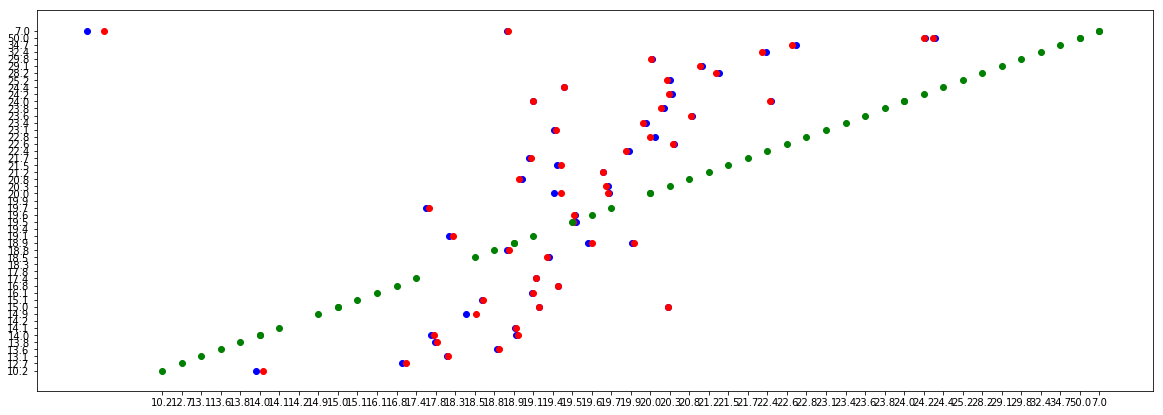

In [155]:
plt.figure(figsize = (20, 7))
plt.scatter(lr70.predict(X_test),y_test, color = 'blue')
plt.scatter(lr90.predict(X_test),y_test, color = 'red')
plt.scatter(y_test,y_test, color = 'green')

In [ ]:
# # scale data
# sscaler = StandardScaler()
# scaled_data = sscaler.fit_transform(cali_df[['MedInc', 'AveRooms']])

In [221]:
# Explore hyperparameters

poly = PolynomialFeatures()
X = poly.fit_transform(X[['DIS']])

rmses = []
for i in [i for i in range(2,20,1)]:
    #X = X[['DIS']]

    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,random_state=42)

    pipe = Pipeline([('poly', PolynomialFeatures(degree=i)), ('lr', LinearRegression())])

    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_test)

    mse = metrics.mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    print(rmse)
    rmses.append(rmse)
    
# 3rd degree performed best    

8.264938637557059
8.20859974564611
7.770018730151967
7.80964623450484
7.977933364705333
7.795727463409459
8.143373190697416
8.2648599695169
8.40798364424902
8.50240589977825
8.581812006011889
8.642851486475628
8.710895451154107
8.727443295871577
8.742623881864606
8.75715442148802
8.764645008815544
8.759190055276846


In [212]:
def modeler (estimator, degree):
    X = X['RM', 'LSTAT', 'DIS', 'AGE']
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,random_state=42)
    pipe = Pipeline([('sscale', StandardScaler()),('poly',PolynomialFeatures(degree=degree)),('lr',estimator)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    return np.sqrt(mse)

In [213]:
degree = [1,2,3]
models = [Ridge(), Lasso()]
for model in models:
    for deg in degree:
        print(modeler(model,deg))

UnboundLocalError: local variable 'X' referenced before assignment

## BONUS: Try the k-fold cross-validation technique described above, varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds? Include a written response.

In [101]:
cross_val_score(lr, X_train, y_train, cv = 5)

NameError: name 'cross_val_score' is not defined

## BONUS
Practice the same workflow you just worked through above, but this time use Statsmodels instead of Sklearn for linear regression. See example formulas below.

### Example: Statsmodels Formulas

Adjust the formula using your chosen metrics from the housing data. Remember, your workflow here is the same, but the syntax is a little different. Describe your results. Are they comparable to scikit-learn's regression models?

In [8]:
# First, format your data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [9]:
# Set up your new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     1220.
Date:                Wed, 29 Nov 2017   Prob (F-statistic):          1.59e-321
Time:                        22:28:38   Log-Likelihood:                -1567.7
No. Observations:                 506   AIC:                             3151.
Df Residuals:                     498   BIC:                             3185.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             4.9744      0.224     22.197      0.000       4.534       5.415
LSTAT         -0.5615      0.048    -11.817      0.000      -0.655      -0.468
RAD            0.2109      0.070      3.025      0.003       0.074       0.348
TAX           -0.0174      0.004     -4.267      0.000      -0.025      -0.009
NOX            4.3456      3.385      1.284      0.200      -2.305      10.997
INDUS          0.0925      0.067      1.385      0.167      -0.039       0.224
CRIM          -0.0866      0.037     -2.362      0.019      -0.159      -0.015
ZN             0.0288      0.013      2.215      0.027       0.003       0.054
==============================================================================
Omnibus:                      192.072   Durbin-Watson:                   0.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              831.634
Skew:                           1.665   Prob(JB):                    2.59e-181
Kurtosis:                       8.325   Cond. No.                     6.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### BONUS:

Can you optimize your R2, selecting the best features? Provide your code and explain your process in a brief written response.

### BONUS:

Given a combination of predictors, can you identify another response variable that could be accurately predicted through the exploration of different predictors in this data set?

_Tip: Consider pairplots, coefficients, or Pearson scores._

In [10]:
# Check out variable relations
import seaborn as sns

sns.pairplot(X);

In [ ]:
# Check out Pearson scores


## BONUS/DEMO: Up for an additional challenge? Try again, this time using the `patsy` library.

In [11]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [12]:
from sklearn.model_selection import train_test_split  #Note: if you didn't import this earlier, you'll need to do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


In [13]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))

R^2 Score: 0.5043486813354807
